In [16]:
##########################
## implement a3 in squin ##
##########################
from bloqade import squin
from bloqade.types import Qubit
from kirin.dialects import ilist
from bloqade.cirq_utils import load_circuit
from bloqade.cirq_utils.emit import emit_circuit
from bloqade.cirq_utils import noise
import bloqade.stim
import numpy as np
from math import pi
from typing import Literal


@squin.kernel
def preparemagicstate(qubit):
    squin.i(qubit)


@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    squin.h(q[6])
    for i in range(6):
        squin.ry(-pi / 2, q[i])
    squin.cz(q[1], q[2])
    squin.cz(q[3], q[4])
    squin.cz(q[5], q[6])
    squin.ry(pi / 2, q[6])
    squin.cz(q[0], q[3])
    squin.cz(q[2], q[5])
    squin.cz(q[4], q[6])
    for i in range(2, 7):
        squin.ry(pi / 2, q[i])
    for i in range(0, 5, 2):
        squin.cz(q[i], q[i + 1])
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[2])
    squin.ry(pi / 2, q[4])

# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding Functions
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode |0⟩^7 → |0⟩_L on the 7-qubit register q (Steane [[7,1,3]])."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode 7 qubits as |+⟩_L: first |0⟩_L then transversal H."""
    steane_encode_zero_on(q)
    for i in range(7):
        squin.h(q[i])


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """A3 circuit implementation in squin."""
    q = squin.qalloc(21)
    
    #steane_encode_zero_on(q[0:7])
    injection(q)
    # Qubits 0-6: logical data
    # Qubits 8-14 + 15-21: ancilla block

    # Prepare ancilla as |+⟩_L for first half (X-stabilizer syndrome)
    steane_encode_plus_on(q[7:14])

    # CNOTs: data → ancilla (X-syndrome extraction)
    for i in range(7):
        squin.cx(q[i], q[i+7])

    # Reset ancilla qubits 8-14
    #for i in range(8, 15):
    #    squin.reset(q[i])
    
    # Prepare ancilla as |0⟩_L for second half (Z-stabilizer syndrome)
    steane_encode_zero_on(q[14:21])

    # CNOTs: ancilla → data (Z-syndrome extraction)
    for i in range(7):
        squin.cx(q[i+14], q[i])

    # Transversal H on ancilla
    for i in range(7):
        squin.h(q[i+14])
    
    # Measure ancilla qubits 7-21 (Syndrome bits)
    for i in range(7, 21):
        squin.measure(q[i])

In [17]:

# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []

# Noise channel
noise_model = noise.GeminiOneZoneNoiseModel(scaling_factor=100)

for i in range(loops):
    # Generate circuit
    cirq_enc = emit_circuit(a3_circuit)
    
    # Apply noise to this circuit
    noisy_cirq_enc = noise.transform_circuit(cirq_enc, model=noise_model)
    
    # Convert to stim circuit and sample
    squin_enc = load_circuit(noisy_cirq_enc)
    stim_enc = bloqade.stim.Circuit(squin_enc)
    sampler = stim_enc.compile_sampler()
    
    # Sample this noisy circuit
    samples = sampler.sample(shots=shots_per_loop)
    all_samples.extend(samples)

samples_enc = np.array(all_samples)

# Show diagram from last circuit
fig = stim_enc.diagram()

print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print(f"Total samples collected: {len(samples_enc)} ({loops} loops × {shots_per_loop} shots)")
print("Sample shape:", samples_enc.shape)
print("First 5 shots:\n", samples_enc[:5])
print(f"Error rate: {np.count_nonzero(samples_enc)/len(samples_enc):.4f}")
fig



MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Total samples collected: 1000 (1 loops × 1000 shots)
Sample shape: (1000, 14)
First 5 shots:
 [[False False  True  True False False False False  True  True False  True
  False  True]
 [False  True  True  True False False False  True False  True  True  True
   True False]
 [False False False False False  True False False False False False False
  False  True]
 [False  True  True  True False  True False False False  True  True  True
  False  True]
 [False False False False  True  True False  True  True  True  True False
   True False]]
Error rate: 6.9110


q0: -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.05149,0.05149,0.2185)--------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)-S_DAG-SQRT_X_DAG-S--------------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.04102,0.04102,0.04112)-PAULI_CHANNEL_1(0.03066,0.03066,0.04639)------------------------------------------PAULI_CHANNEL_1(0.05149,0.05149,0.2185)--------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)-------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.0806,0.0806,0.2458)-------------------------------------------------@-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_2[0](0.0227472,0.0227472,0.151278,0.0227472,0.0142864,0.0142864,0.0143083,0.0227472,0.0142864,0.0142864,0.0143083,0.151278,0.0143083,0.0143083,0.142814)-PAULI_CHANNEL_1(0.0806,0.0806,0.2458)------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.0806,0.0806,0.2458)----@----------------------------------------PAULI_CHANNEL_2[0](0.0227472,0.0227472,0.151278,0.0227472,0.0142864,0.0142864,0.0143083,0.0227472,0.0142864,0.0142864,0.0143083,0.151278,0.0143083,0.0143083,0.142814)-PAULI_CHANNEL_1(0.0806,0.0806,0.2458)-----------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)--------------------------------------------PAULI_CHANNEL_1(0.05149,0.05149,0.2185)--------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)-------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)------------------------------------------PAULI_CHANNEL_1(0.05149,0.05149,0.2185)--------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)---------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)------------------------------------------PAULI_CHANNEL_1(0.05149,0.05149,0.2185)--------------------------------------------------------------------------------------------------------------------------------PAULI_CHANNEL_1(0.03066,0.03066,0.04639)---------------

In [18]:
synd_dict = {1:[1,3,5,7],2:[4,5,6,7],3:[2,3,6,7]}

In [19]:
def to_parity(li):
    li_new = [-2*el+1 for el in li]
    return li_new

li = [False, True, False]

In [20]:
def find_syndrome(li, idx):
    li = to_parity(li)
    mult = 1
    for ind in idx:
        mult *= li[ind-1]
    return True if mult == 1 else False


In [21]:
def findZSyndrome(sample,idx):
    sample_z = sample[0:7]
    return find_syndrome(sample_z,idx)

def findXSyndrome(sample,idx):
    sample_x = sample[7:14]
    return find_syndrome(sample_x,idx)

In [22]:
def compute_syndromes(sample,ind_dict):
    x_synds = []
    z_synds = []
    for key in list(ind_dict.keys()):
        idx = ind_dict[key]
        x_synds.append(findXSyndrome(sample,idx))
        z_synds.append(findZSyndrome(sample,idx))
    return x_synds,z_synds

In [23]:
def find_good_rate(samples,ind_dict):
    tot_samples = len(samples)
    good_samples = 0
    for sample in samples:
        synd = compute_syndromes(sample,ind_dict)
        will_add = 1 if np.count_nonzero(synd) == 6 else 0
        good_samples+=will_add
    return (good_samples)/len(samples)

In [24]:
print(find_good_rate(samples_enc,synd_dict))

0.011


0


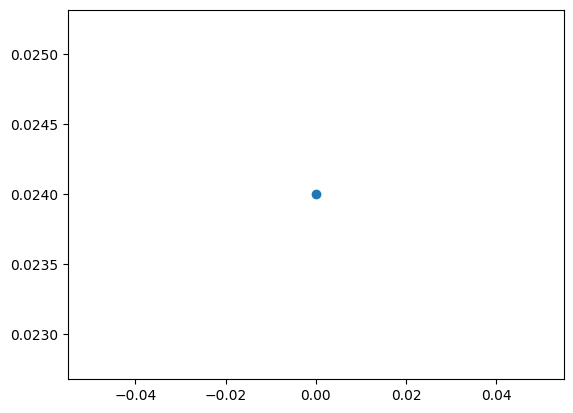

In [31]:

import matplotlib.pyplot as plt
# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []
fidelities = []

coeffs = np.arange(0.5,1.5,0.1)
coeffs = [0]

for coeff in coeffs:
    print(coeff)
    # Noise channel
    noise_model = noise.GeminiOneZoneNoiseModel(scaling_factor=coeff)

    for i in range(loops):
        # Generate circuit
        cirq_enc = emit_circuit(a3_circuit)
        
        # Apply noise to this circuit
        noisy_cirq_enc = noise.transform_circuit(cirq_enc, model=noise_model)
        
        # Convert to stim circuit and sample
        squin_enc = load_circuit(noisy_cirq_enc)
        stim_enc = bloqade.stim.Circuit(squin_enc)
        sampler = stim_enc.compile_sampler()
        
        # Sample this noisy circuit
        samples = sampler.sample(shots=shots_per_loop)
        all_samples.extend(samples)

    samples_enc = np.array(all_samples)
    fidelities.append(find_good_rate(samples_enc,synd_dict))

plt.scatter(coeffs,fidelities)
plt.show()
    



In [11]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Model: y = A * p^(-n)
def scaling(p, A, n):
    return A * np.power(p, -n)

In [12]:
n0 = 1.0
A0 = fidelities[0] * (coeffs[0] ** n0)  # rough guess
p0 = (A0, n0)

In [13]:
popt, pcov = curve_fit(scaling, coeffs, fidelities, p0=p0, maxfev=10000)
A_fit, n_fit = popt
A_err, n_err = np.sqrt(np.diag(pcov))

print(f"A = {A_fit:.6g} ± {A_err:.2g}")
print(f"n = {n_fit:.6g} ± {n_err:.2g}")

A = 0.567686 ± 0.0032
n = 0.254892 ± 0.015


In [14]:
funcs = scaling(coeffs,A_fit,n_fit)

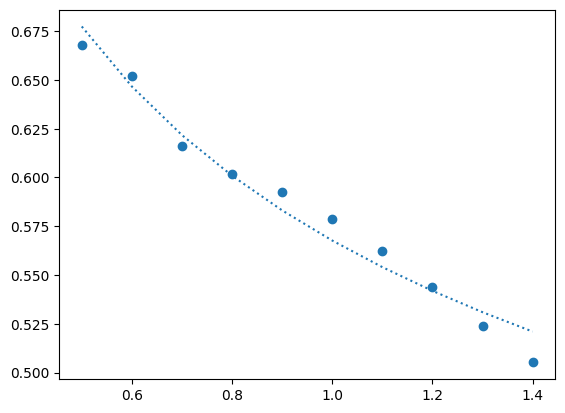

In [15]:
plt.scatter(coeffs,fidelities)
plt.plot(coeffs,funcs,ls = ":")
plt.show()